In [1]:
import pandas as pd
import os
# %matplotlib widget
%matplotlib inline
import matplotlib.pyplot as plt
import random
import seaborn
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# Load and Cleanup datasets:

In [2]:
def fillMissingMeasurments(df):
    # Create a list that contain the hours of expected measurments 
    hours = list(range(0, 24))
    expectedTimes = []
    for hour in hours:
        minutes = list(range(0, 60, 5))
        for minute in minutes:
            expectedTimes.append('{:02d}'.format(hour) + ":" + '{:02d}'.format(minute))
    # Extract the date from the incomplete df
    date = df["Date"].iloc[0]
    # For every missing row add a null row with values only at Time and Date columns
    i = 0
    for time in expectedTimes:
        # Create an empty row as a dictionary
        null_row = pd.DataFrame.from_dict({"Time": [time], "Date": [date]})
        if i >= len(df.index):
            # Missing values at the end of the dataframe
            df = pd.concat([df, null_row], ignore_index=True)
            df.reset_index(drop=True)
        elif time != df.iloc[i]["Time"]:
            # Missing values are inside the dataframe rows
            temp = pd.concat([df[:i], null_row], ignore_index=True)
            df = pd.concat([temp, df.iloc[i:]], ignore_index=True)
            df.reset_index(drop=True)
        i+=1
    return df

In [3]:
# Given a folder full of .csv files, return a data frame
# containing all the data. 
# relPathToFolder example (../path/to/folder/)
def getFolderToDataframe(relPathToFolder):
    # Initialize an empty dataframe
    df = pd.DataFrame()
    # Forall files in the directory
    for day in os.listdir(relPathToFolder):
        curFile = relPathToFolder + day
        if os.stat(curFile).st_size == 0 : continue
        # Fix Time and Date into a datetime object
        tempDf = pd.read_csv(curFile)
        tempDf["Date"] = day.split(sep='.')[0]
        # Remove redundant row (measurment for time 00:00 of the next day)
        # How I came up with 288: 
        # (24h in a day = 1440 minutes => 1440/5 = 288 measurments => measurments[0:287] 
        #   => iloc does not include the right bound, hence 288)
        tempDf = tempDf.iloc[0:288]
        if(len(tempDf.index) != 288):
            tempDf = fillMissingMeasurments(tempDf)
            if(len(tempDf.index) != 288):
                raise Exception("Missing rows, size of data = " + str(len(tempDf.index)))
        # Append tempDf to the old one
        df = pd.concat([df, tempDf], ignore_index=True)
    # Convert Date and Time into objects 
    df["Date"] = pd.to_datetime(df["Date"], format="%Y%m%d").dt.date
    df["Time"] = pd.to_datetime(df["Time"], format="%H:%M").dt.time
    # Reset indexes and drop the indexes for each individual day
    return df

In [4]:
# Functions that will prepare dataframes for clustering - substitute NaNs with actual values (averages)

# Fill NaNs in df with the average of that time of the other days
def substituteNanWithTimeAvg(df):
    avgDf = df.groupby("Time").mean().reset_index()
    for key, values in df.iteritems():
        cnt = -1
        for value in values:
            cnt += 1
            if pd.isna(value):
                row = df.iloc[cnt]
                df.loc[(df["Time"] == row.Time) & (df["Date"] == row.Date), key] = avgDf.loc[avgDf["Time"] == row.Time, key].item()


# Substitute NaNs in df with the average values of the previous 2 hours and the next 2 hours of the NaN measurement
# Ended up not using this function because it was also returning a few NaNs
def get4hourAverage(colName, df, date, time, hours=2):
    dateDf = df.loc[df.Date == date]
    dateDf.Time = dateDf["Time"].apply(lambda x: int(x.strftime('%H%M')))
    minuteStr = time.strftime('%H%M')[-2:]
    startHour = int(time.strftime('%H')) - hours
    if startHour < 0:
        startHour = 24 + startHour
    endHour = int(time.strftime('%H')) + hours
    if endHour > 23:
        endHour = endHour - 24
    startTime = int(f"{startHour:02d}" + minuteStr)
    endTime = int(f"{endHour:02d}" + minuteStr)
    if(startHour > endHour):
        avg = dateDf.loc[(dateDf.Time >= startTime) | (dateDf.Time <= endTime)][colName]
        return avg.mean()
    avg = dateDf.loc[(dateDf.Time >= startTime) & (dateDf.Time <= endTime)][colName]
    return avg.mean()

In [5]:
# Load demand
demandDf = getFolderToDataframe("../resources/demand/")
demandDf = demandDf.rename(columns={"Current demand": "current_demand", "Hour ahead forecast": "hour_ahead_forecast", "Day ahead forecast": "day_ahead_forecast"})
demandDf.describe().T

## Fill NaNs in demandDf
substituteNanWithTimeAvg(demandDf)
if demandDf.isnull().values.any():
    raise Warning("demandDf still has NaN values!")

In [6]:
# Load sources
sourcesDf = getFolderToDataframe("../resources/sources/")

## Cleanup
# Noticed that sources dataframe has two columns with same name but different capitalization.

# Natural gas - Natural Gas
# Important: Check if there are rows where both columns contain a value
cntBothNotNaN_gas = sourcesDf.loc[~((pd.isnull(sourcesDf["Natural gas"])) | (pd.isnull(sourcesDf["Natural Gas"])))]["Date"].count()
print(f"Natural gas: {cntBothNotNaN_gas} rows where both columns contain an actual value")

# Large hydro - Large Hydro
# Important: Check if there are rows where both columns contain a value
cntBothNotNaN_hydro = sourcesDf.loc[~((pd.isnull(sourcesDf["Large hydro"])) | (pd.isnull(sourcesDf["Large Hydro"])))]["Date"].count()
print(f"Large hydro: {cntBothNotNaN_hydro} rows where both columns contain an actual value")

if cntBothNotNaN_gas or cntBothNotNaN_hydro: raise Exception("There are conflicting values in your dataset")

# Since there are no conflicting values - I may change the capitalization and merge the columns
# Convert all column names to lowercase
sourcesDf.columns = sourcesDf.columns.str.lower()

# Sum the values of the distinct columns into one
sourcesDf[["temp natural gas", "temp large hydro"]] = sourcesDf[["natural gas", "large hydro"]].groupby(level=0, axis=1).sum()
# Drop the redundant columns
sourcesDf = sourcesDf.drop(columns=["natural gas", "large hydro"])
# Rename temp columns to their final names
# Also fix date and time so it works with my hardcoded strings in plotColumnByTime_forDates()
sourcesDf.rename(columns={
    "temp natural gas": "natural gas",
    "temp large hydro": "large hydro",
    "date": "Date",
    "time": "Time"
    }, inplace="True")

## Print the statistics of the clean dataset
print(sourcesDf.describe().T)

## Fill NaNs in sourcesDf
substituteNanWithTimeAvg(sourcesDf)
if sourcesDf.isnull().values.any():
    raise Warning("sourcesdDf still has NaN values!")

Natural gas: 0 rows where both columns contain an actual value
Large hydro: 0 rows where both columns contain an actual value
                count         mean          std       min     25%     50%  \
solar        315594.0  3560.611615  4373.706624    -145.0   -34.0   114.0   
wind         315594.0  2021.702320  1300.586403   -2476.0   869.0  1833.0   
geothermal   315306.0   890.270693   115.981209    -134.0   866.0   909.0   
biomass      315594.0   311.255357    48.244726     125.0   279.0   315.0   
biogas       315594.0   212.566969    15.383158     101.0   204.0   213.0   
small hydro  315594.0   264.017126   778.106278   -2826.0   166.0   227.0   
coal         315594.0    14.244108     4.574650      -8.0    11.0    15.0   
nuclear      315594.0  1866.838238   578.834088     -74.0  1145.0  2259.0   
batteries    315594.0    -5.018828   191.050928   -1614.0   -31.0    -3.0   
imports      315306.0  6029.318386  2614.757272  -22949.0  4250.0  6466.0   
other        315594.0     0

# Plot:
In order to find correlations between the variables of the datasets

In [7]:
def plotColumnByTime_forDates(df, colName, numOfDays, ax, listOfDays=[]):
    t = df[["Date", "Time", colName]].groupby("Date")
    daysInList = list(t.groups)
    if not len(listOfDays):
        listOfDays = [random.randint(0, len(daysInList)-1) for i in range(0,numOfDays)]
    for dateId in listOfDays:
        date = daysInList[dateId]
        temp = df.loc[df["Date"] == date]
        ax.plot(temp["Time"].apply(lambda x: int(x.strftime('%H%M'))), temp[colName], label=date)
    ax.legend()
    ax.set_xlabel("Time (%H%M)")
    ax.set_ylabel(colName)

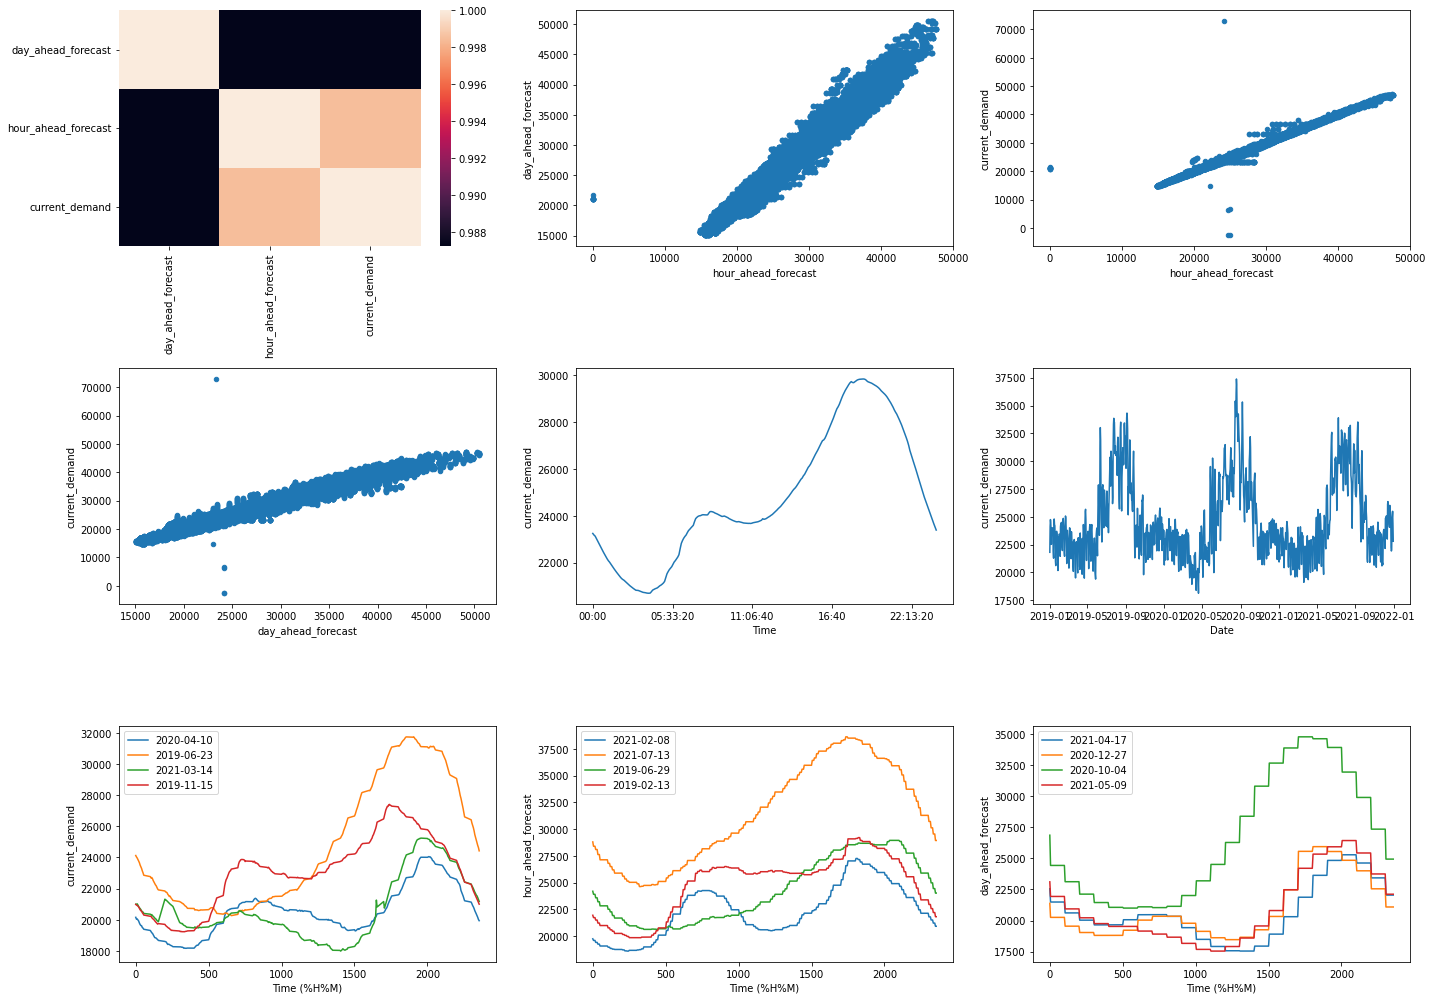

In [8]:
## Plot demand dataframe
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5), (ax6, ax7, ax8)) = plt.subplots(3, 3, figsize=(20,14))

# Correlation plot
demandCorrMat = demandDf.corr()
seaborn.heatmap(demandCorrMat, xticklabels=demandCorrMat.columns, yticklabels=demandCorrMat.columns, ax=ax0)

# Setup the scatter plots (Correlating data on the same row)
demandDf.plot.scatter(ax=ax1, x='hour_ahead_forecast', y='day_ahead_forecast')
demandDf.plot.scatter(ax=ax2, x='hour_ahead_forecast', y='current_demand')
demandDf.plot.scatter(ax=ax3, x='day_ahead_forecast', y='current_demand')

# Setup line plots (Correlating data on datetime)
demandDf[["Time", "current_demand"]].groupby("Time").mean().plot(ax=ax4, ylabel="current_demand", legend=False)
demandDf[["Date", "current_demand"]].groupby("Date").mean().plot(
    ax=ax5,
    xlabel="Date", ylabel="current_demand", legend=False
    )
plotColumnByTime_forDates(demandDf, "current_demand", 4, ax6)
plotColumnByTime_forDates(demandDf, "hour_ahead_forecast", 4, ax7)
plotColumnByTime_forDates(demandDf, "day_ahead_forecast", 4, ax8)
plt.tight_layout()

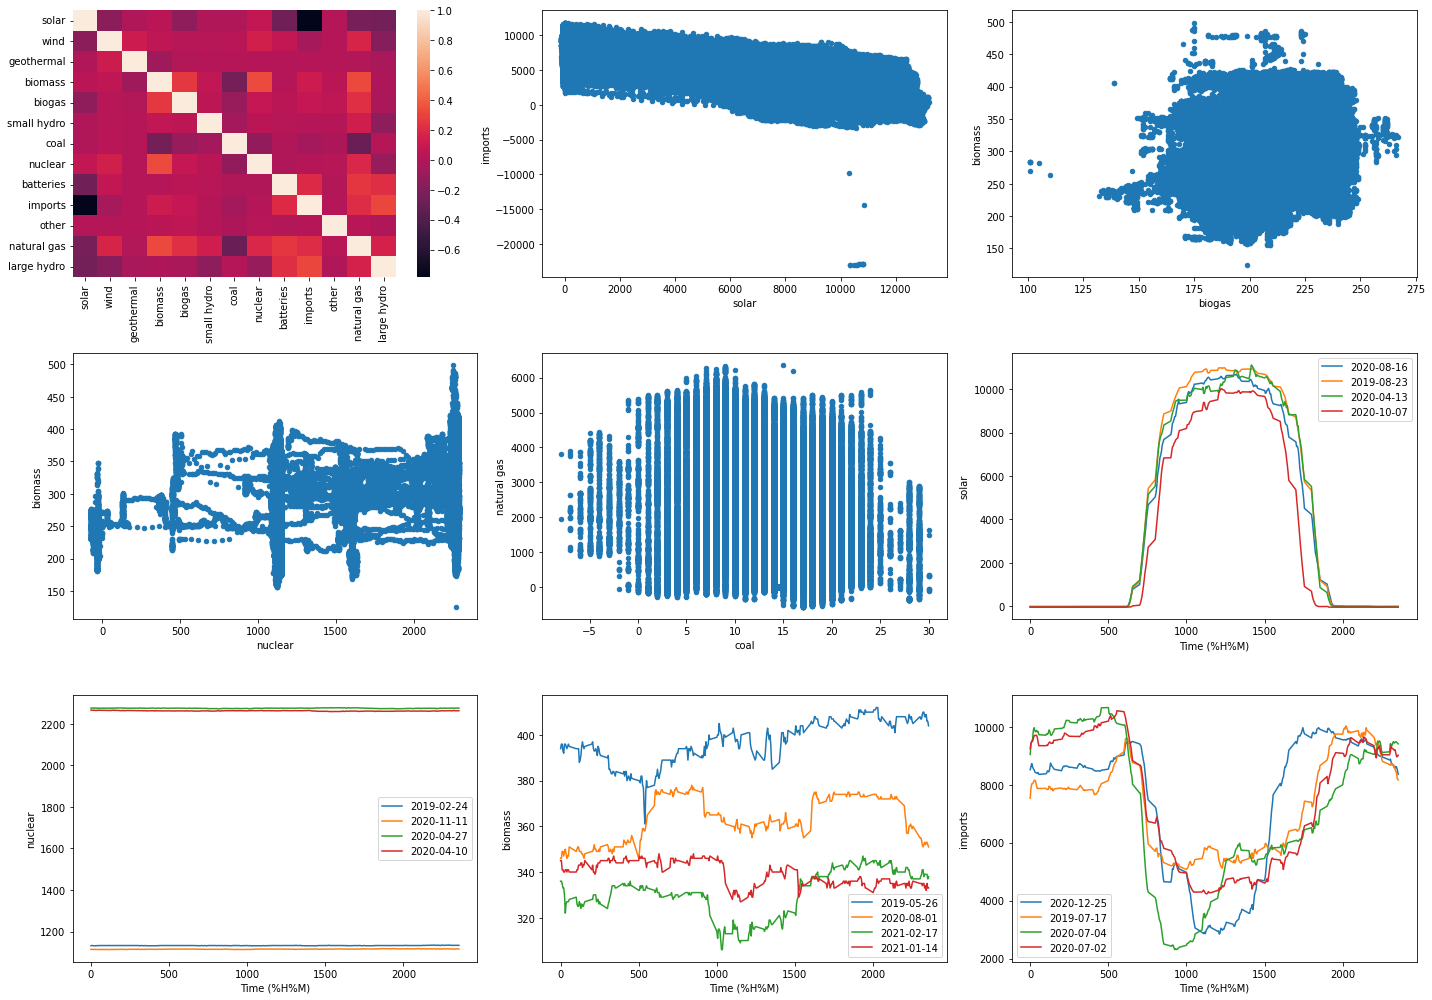

In [9]:
## Plot the sources dataframe
fig2, ((ax20, ax21, ax22), (ax23, ax24, ax25), (ax26, ax27, ax28)) = plt.subplots(3, 3, figsize=(20,14))
sourcesCorrMat = sourcesDf.corr()
seaborn.heatmap(sourcesCorrMat, xticklabels=sourcesCorrMat.columns, yticklabels=sourcesCorrMat.columns, ax=ax20)

sourcesDf.plot.scatter(ax=ax21, x='solar', y='imports')
sourcesDf.plot.scatter(ax=ax22, x='biogas', y='biomass')
sourcesDf.plot.scatter(ax=ax23, x='nuclear', y='biomass')
sourcesDf.plot.scatter(ax=ax24, x='coal', y='natural gas')

plotColumnByTime_forDates(sourcesDf, "solar", 4, ax25)
plotColumnByTime_forDates(sourcesDf, "nuclear", 4, ax26)
plotColumnByTime_forDates(sourcesDf, "biomass", 4, ax27)
plotColumnByTime_forDates(sourcesDf, "imports", 4, ax28)

plt.tight_layout()

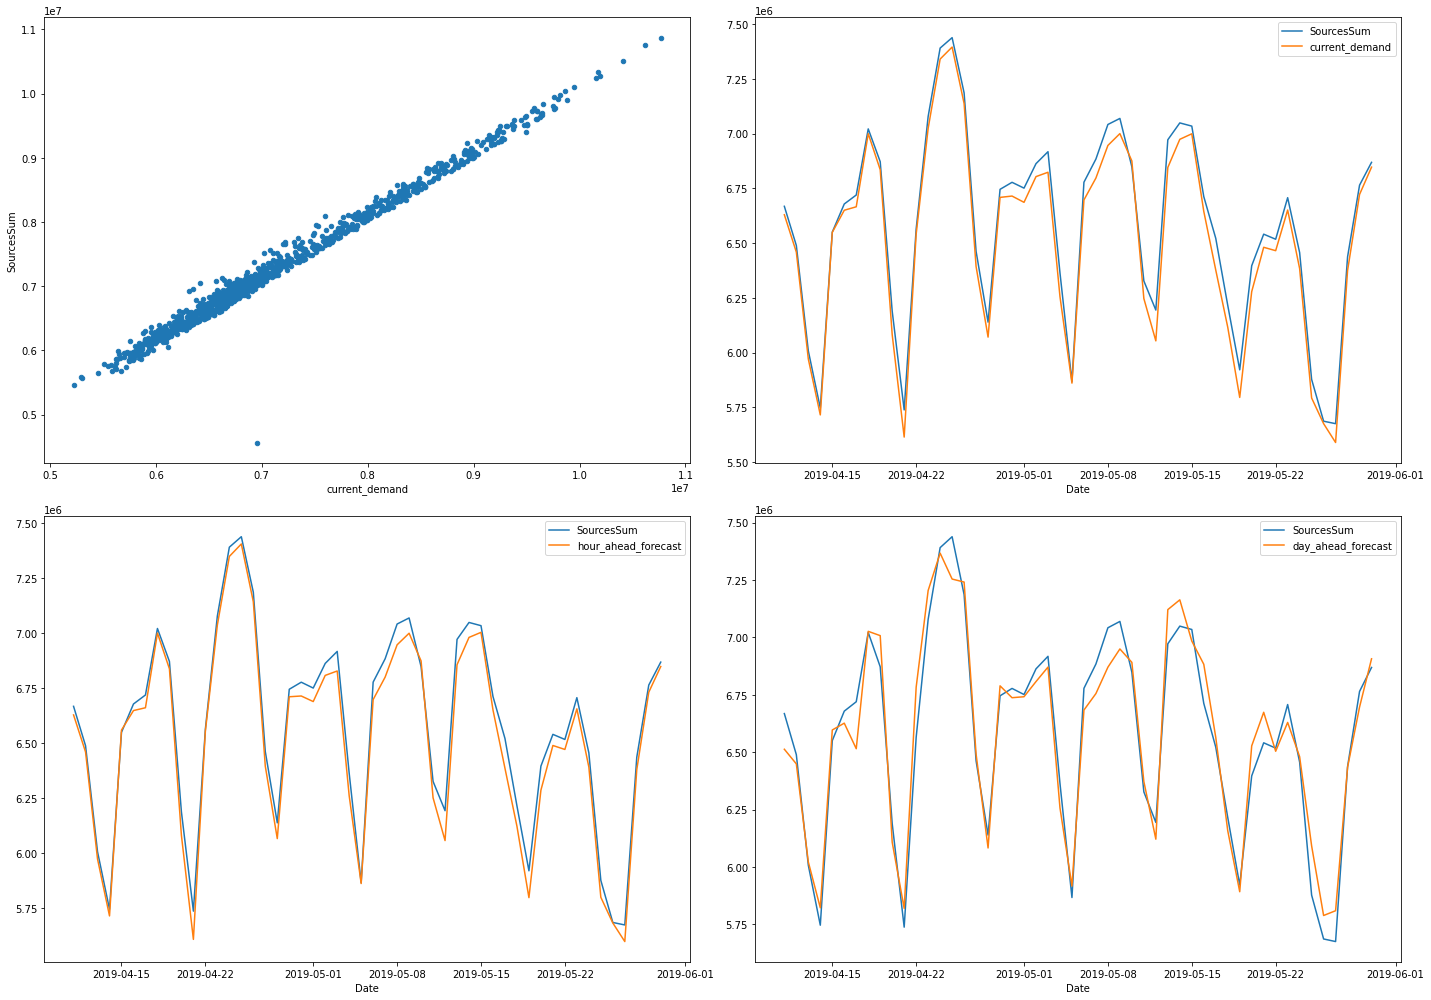

In [10]:
## Do some more analysis, combining data from both datasets

# Get the sum of all the energy sources for each day
dailySourcesDf = sourcesDf.groupby("Date").sum().reset_index()
dailySourcesDf["SourcesSum"] = dailySourcesDf.drop("Date", axis=1).sum(axis=1)
dailySourcesDf = dailySourcesDf[["Date", "SourcesSum"]]

# Get the sum of the energy demand for each day (do the same for the forecasts aswell)
dailyDemandDf = demandDf.groupby("Date").sum().reset_index()

# Combine the two dataframes
dailyDemandSourcesDf = pd.merge(left=dailyDemandDf, right=dailySourcesDf, how="outer", on="Date")

# Plots
fig3, ((ax29, ax30), (ax31, ax32)) = plt.subplots(2, 2, figsize=(20,14))
dailyDemandSourcesDf.plot.scatter(x="current_demand", y="SourcesSum", ax=ax29)
dailyDemandSourcesDf[100:150].plot.line(x="Date", y=["SourcesSum", "current_demand"], ax=ax30)
dailyDemandSourcesDf[100:150].plot.line(x="Date", y=["SourcesSum", "hour_ahead_forecast"], ax=ax31)
dailyDemandSourcesDf[100:150].plot.line(x="Date", y=["SourcesSum", "day_ahead_forecast"], ax=ax32)

plt.tight_layout()

# Clustering:

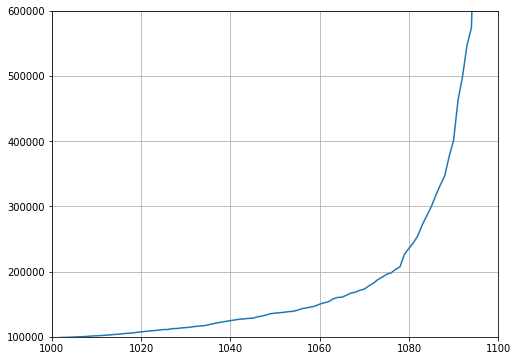

In [11]:
# Extract the usefull columns for the clustering
demandClusterDf = dailyDemandDf[["current_demand", "hour_ahead_forecast", "day_ahead_forecast"]]

# min_pts = 2*dimension_of_dataframe
min_pts = 6

# Create a kdistance graph in order to estimate the best eps value for DBSCAN.
def plot_kdistance(df, min_pts, xmin=np.nan, xmax=np.nan, ymin=np.nan, ymax=np.nan):
    neighbors = NearestNeighbors(n_neighbors=min_pts)
    neighbors_fit = neighbors.fit(df)
    distances, _ = neighbors_fit.kneighbors(df)
    distances = np.sort(distances, axis=0)
    distances = distances.mean(axis=1)
    fig = plt.figure(figsize=(8, 6))
    axes = plt.axes()
    if xmin is not np.nan and xmax is not np.nan and ymin is not np.nan and ymax is not np.nan:
        axes.set_xlim(xmin, xmax)
        axes.set_ylim(ymin, ymax)
    axes.grid()
    axes.plot(distances)

plot_kdistance(demandClusterDf, min_pts, 1000, 1100, 100000, 600000)

In [12]:
# Run DBSCAN
eps = 220000
dbscanObj = DBSCAN(eps=eps, min_samples=min_pts, n_jobs=-1).fit(demandClusterDf)
clusters = dbscanObj.labels_
print(f"Number of outlier days in demand df: {sum(clusters == -1)}")
print(dailyDemandDf.iloc[demandClusterDf[clusters == -1].index]["Date"])

Number of outlier days in demand df: 18
229    2019-08-18
453    2020-03-29
466    2020-04-11
467    2020-04-12
474    2020-04-19
591    2020-08-14
592    2020-08-15
594    2020-08-17
595    2020-08-18
596    2020-08-19
597    2020-08-20
598    2020-08-21
599    2020-08-22
601    2020-08-24
603    2020-08-26
614    2020-09-06
615    2020-09-07
616    2020-09-08
Name: Date, dtype: object


In [13]:
# Function that will plot the clusters in order to visually confirm that outliers are marked as expected
def show_clusters_3d(df, clusters, colNames):
    df["Cluster"] = clusters.tolist()
    colors = {-1: "red", 0: "blue", 1:"orange", 2:"green", 3:"skyblue", 4: "gray", 5: "black", 6: "purple"}
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    grouped = df.groupby('Cluster')
    # print(grouped.groups.keys())
    for key, group in grouped:
        ax.scatter(group.iloc[:,0], group.iloc[:,1], group.iloc[:,2], label=key, color=colors[key])
    plt.title("DBSCAN for min_points = " + str(min_pts) + ", eps = " + str(eps))
    plt.show()

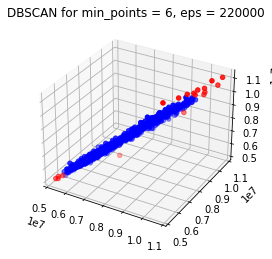

In [14]:
show_clusters_3d(demandClusterDf, clusters, ["current_demand", "hour_ahead_forecast", "day_ahead_forecast"])

Number of outlier days in sources df: 5
1      2019-01-02
273    2019-10-01
595    2020-08-18
922    2021-07-11
941    2021-07-30
Name: Date, dtype: object


C:\Users\Vasilis\AppData\Local\Temp\ipykernel_3148\282362369.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Cluster"] = clusters.tolist()


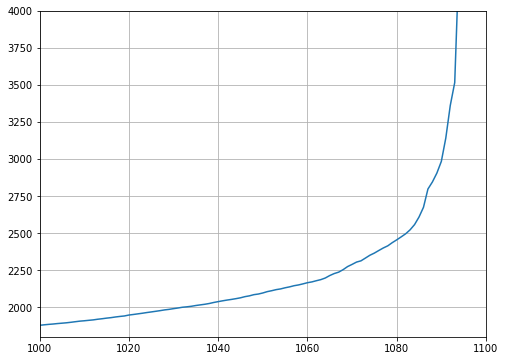

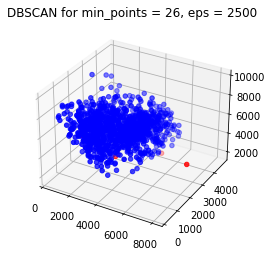

In [15]:
sourcesClusterDf_withDate = sourcesDf.groupby("Date").mean().reset_index()
sourcesClusterDf = sourcesClusterDf_withDate.drop("Date", axis=1)
min_pts = 26
plot_kdistance(sourcesClusterDf, min_pts, 1000, 1100, 1800, 4000)

eps = 2500
dbscanObj = DBSCAN(eps=eps, min_samples=min_pts, n_jobs=-1).fit(sourcesClusterDf)
# DBSCAN using mahalanobis distance
# covMat = np.cov(sourcesClusterDf.T)
# dbscanObj = DBSCAN(eps=eps, min_samples=min_pts, n_jobs=-1, metric="mahalanobis", metric_params={"V": covMat}).fit(sourcesClusterDf)
clusters = dbscanObj.labels_
print(f"Number of outlier days in sources df: {sum(clusters == -1)}")
print(sourcesClusterDf_withDate.iloc[sourcesClusterDf[clusters == -1].index]["Date"])
temp = sourcesClusterDf[["solar", "wind", "imports"]]
show_clusters_3d(temp, clusters,  ["solar", "wind", "imports"])

In [16]:
def plot2dClusters(df, clusters):
    df["Cluster"] = clusters.tolist()
    colors = {-1: "red", 0: "blue", 1:"orange", 2:"green", 3:"skyblue", 4: "gray", 5: "black", 6: "purple"}
    fig = plt.figure()
    ax = plt.axes()
    grouped = df.groupby('Cluster')
    # print(grouped.groups.keys())
    for key, group in grouped:
        ax.scatter(group.iloc[:,0], group.iloc[:,1], label=key, color=colors[key])
    plt.title("DBSCAN for min_points = " + str(min_pts) + ", eps = " + str(eps))
    plt.show()

Number of outlier days in combined df: 14
1       2019-01-02
466     2020-04-11
467     2020-04-12
474     2020-04-19
591     2020-08-14
592     2020-08-15
594     2020-08-17
595     2020-08-18
596     2020-08-19
614     2020-09-06
1078    2021-12-14
1088    2021-12-24
1089    2021-12-25
1090    2021-12-26
Name: Date, dtype: object


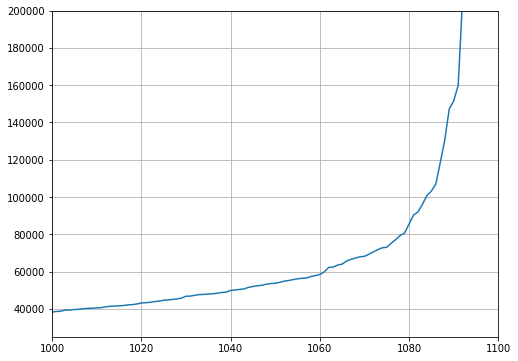

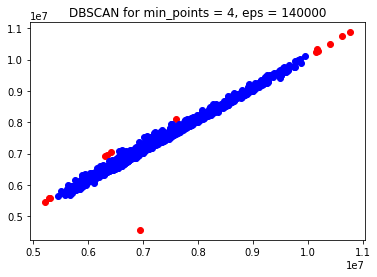

In [17]:
# Cluster dailyDemandSourcesDf
dailyDemandSourcesClusterDf_withDate = dailyDemandSourcesDf.groupby("Date").mean().reset_index()
dailyDemandSourcesClusterDf = dailyDemandSourcesClusterDf_withDate.drop("Date", axis=1)[["current_demand", "SourcesSum"]]
min_pts = 4
plot_kdistance(dailyDemandSourcesClusterDf, min_pts, 1000, 1100, 25000, 200000)

eps = 140000
dbscanObj = DBSCAN(eps=eps, min_samples=min_pts, n_jobs=-1).fit(dailyDemandSourcesClusterDf)

clusters = dbscanObj.labels_
print(f"Number of outlier days in combined df: {sum(clusters == -1)}")
print(dailyDemandSourcesClusterDf_withDate.iloc[dailyDemandSourcesClusterDf[clusters == -1].index]["Date"])
plot2dClusters(dailyDemandSourcesClusterDf, clusters)

# Μέρος Γ

In [ ]:
X=sourcesDf[['Time','coal','nuclear','natural gas']]

In [ ]:
X

In [ ]:
Y=demandDf[['current_demand']]

In [ ]:
Y

In [ ]:
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()
#ss2 = StandardScaler()

X_ss = ss.fit_transform(X[['coal','nuclear','natural gas']])
Y_mm = mm.fit_transform(Y) 

In [ ]:
#split in trainset/testset at 80/20 ratio

X_train = X_ss[:252518, :]
X_test = X_ss[252518:, :]

Y_train = Y_mm[:252518, :]
Y_test =Y_mm[252518:, :]

In [ ]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

Y_train_tensors = Variable(torch.Tensor(Y_train))
Y_test_tensors = Variable(torch.Tensor(Y_test))

In [ ]:
X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

In [ ]:
print("Training Shape", X_train_tensors_final.shape, Y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, Y_test_tensors.shape)